In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, \
              auc, mean_squared_error, accuracy_score
import math
plt.rcParams["figure.figsize"] = (12,6)
from sklearn.model_selection import cross_val_score

# SK-learn

## Выделение признаков

In [22]:
# bag of words
#texts представляет собой 3 предложения
texts = [['i', 'have', 'a', 'cat'],
         ['he', 'have', 'a', 'dog'],
         ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]
# corpus - это список всех слов,которые есть в нашем предложении.
corpus = texts[0] + texts[1] + texts[2]

#создаем set чтобы удалить повторы из выше нашего множества(словаря) и получаем словарь всех слов,которые попадают в наш словарь.
#у каждого слова есть номер(номер ячейки)
dictionary = list(enumerate(set(corpus)))

def vectorize(text):
    # vector - формируем вектор пустой длины нашего словаря и далее заполняем вектор теми словами,которые есть в предложении
    # т.е. на те места, которые соответсвуют нашим словам,устанавливаются нужные значения.
    # i, word - так как i наш номер(индекс в словаре), word - само наше слово.
    vector = np.zeros(len(dictionary))
    for i, word in dictionary:
        num = 0
        for w in text:
            if w == word:
                num += 1
        if num:
            vector[i] = num
    return vector

for t in texts:
    print(vectorize(t))
    
#ПРЕДЛОЖЕНИЕ КОДИРУЕТСЯ ВЕКТОРОМ

[1. 0. 1. 1. 0. 0. 1.]
[0. 1. 1. 0. 1. 0. 1.]
[1. 1. 1. 1. 1. 2. 2.]


In [21]:
set(corpus)

{'a', 'and', 'cat', 'dog', 'have', 'he', 'i'}

In [20]:
dictionary

[(0, 'i'),
 (1, 'he'),
 (2, 'have'),
 (3, 'cat'),
 (4, 'dog'),
 (5, 'and'),
 (6, 'a')]

In [18]:
corpus

['i',
 'have',
 'a',
 'cat',
 'he',
 'have',
 'a',
 'dog',
 'he',
 'and',
 'i',
 'have',
 'a',
 'cat',
 'and',
 'a',
 'dog']

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer использует стоп-слова
#ngram_range=(1,1) - В данном случае обозначает, что можно использовать для оптимизации набор из одного слова.
vect = CountVectorizer(ngram_range=(1,1)) 

vect.fit_transform(['no i have cows', 'i have no cows']).toarray()
#vect.vocabulary_

#vect = CountVectorizer(ngram_range=(1,2)) 

#vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

vect.vocabulary_


{'no': 2, 'have': 1, 'cows': 0}

In [24]:
from scipy.spatial.distance import euclidean
# analyzer='char_wb' говорит анализируй посимвольно и можно пробелы использовать...
vect = CountVectorizer(ngram_range=(3,3), analyzer='char_wb') 

n1, n2, n3, n4 = vect.fit_transform(['иванов', 'петров', 'петренко', 'смит']).toarray()
# euclidean возвращает евклидово расстояние между нашими словами
#euclidean(n1, n2)

In [25]:
euclidean(n1, n2)

3.1622776601683795

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from scipy.misc import face
import numpy as np

resnet_settings = {'include_top': False, 'weights': 'imagenet'}
resnet = ResNet50(**resnet_settings)

img = image.array_to_img(face())
# какой милый енот! 
img = img.resize((224, 224))
# в реальной жизни может понадобиться внимательнее относиться к ресайзу
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# нужно дополнительное измерение, т.к. модель рассчитана на работу с массивом изображений

features = resnet.predict(x/255)

1/1 [==============================] - 2s 2s/step


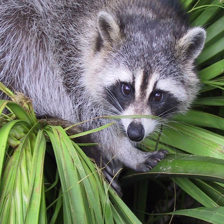

In [9]:
img

## обработка признаков

In [26]:
#проекция на окружность для часов

def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

In [27]:
euclidean(make_harmonic_features(23), make_harmonic_features(1))

0.5176380902050424

In [7]:
!pip install tensorflow

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=b948cbbb7acb637f430b85827b81528fe26e5400e4143de8bae5b79f94d34905
  Stored in directory: c:\users\laptop\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


## Отбор признаков

In [10]:
# границы дисперсии
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
x_data_generated, y_data_generated = make_classification()

x_data_generated.shape

#– пример,как установить порог дисперсии и выкинуть ненужные признаки.
#что имеет низкую вариацию,выкидываем(дисперсия ниже 0.9 например.)
# и далее уже по оставшимся признакам анализируем.

(100, 20)

In [11]:
X = VarianceThreshold(0.7).fit_transform(x_data_generated)
#  VarianceThreshold(0.7).fit_transform(x_data_generated).shape


(100, 19)

In [ ]:
X.shape

In [12]:
# Отбор по влиянию на целевую переменную
from sklearn.feature_selection import SelectKBest, f_classif

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()

-0.18957820903402128

In [13]:
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='neg_log_loss').mean()

-0.13682087087932765

In [14]:
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='neg_log_loss').mean()

-0.1608364791141705

In [74]:
# Отбор с помощью моделей

In [15]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes = 16, 
                                 bootstrap=False, max_features=0.6,
                                 max_samples=1,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(x_data_generated, y_data_generated)

RandomForestClassifier(bootstrap=False, max_features=0.6, max_leaf_nodes=16,
                       max_samples=1, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [16]:
#вероятность влияние значений! смотрим как значения влияют на целевую переменную
rnd_clf.feature_importances_

array([3.28060581e-02, 1.09894842e-01, 1.36000000e-03, 9.46666667e-04,
       1.50187512e-02, 1.61437681e-03, 8.86345811e-04, 7.64356025e-01,
       1.51388235e-03, 3.80498934e-02, 8.93423203e-03, 1.20000000e-03,
       7.48145218e-03, 2.08078204e-03, 1.34605128e-03, 6.58973408e-04,
       1.31839317e-03, 1.18666667e-03, 1.10648829e-03, 8.24011950e-03])

In [28]:
# Перебор
from sklearn.feature_selection import SequentialFeatureSelector
selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', n_features_to_select=3, n_jobs=-1)
#передаем прогнозатор(LogisticRegression), n_features_to_select=3 - перебирает все множества по 3 фичи и выдаст 3 признака,которые оптимальны для решения задачи
# в нашем примере для логистической регрессии.
selector.fit(x_data_generated, y_data_generated)



SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=3, n_jobs=-1,
                          scoring='neg_log_loss')

In [29]:
selector.transform(x_data_generated)

array([[ 0.40175201, -2.85806929,  2.5122225 ],
       [ 1.02530284,  1.14201596,  0.85779585],
       [ 0.28399183, -1.4804467 , -0.85808298],
       [-0.08438431, -0.69296194,  1.27969611],
       [ 0.29637665,  0.394094  , -0.75026139],
       [ 0.1180695 ,  0.08230351, -1.27289709],
       [-1.91043454, -1.29973901, -0.96088848],
       [-1.13215341, -0.56736143, -0.8920552 ],
       [ 1.23717374, -0.56022832,  0.87403553],
       [-2.09156509, -0.92293175, -1.00142231],
       [ 0.92615961, -1.77958439, -0.38937935],
       [ 1.34773811,  0.32309028, -0.20475689],
       [ 0.01663806,  0.04600938, -1.17798225],
       [ 1.38176031,  0.62451493,  0.49455629],
       [-0.1197803 ,  0.91311208,  1.24444922],
       [-1.31268016, -0.96275002, -0.88318438],
       [ 0.06976516,  0.58640092,  1.45084244],
       [-0.3933514 ,  1.51494443,  0.16625958],
       [ 0.20073067, -1.15727362, -1.18408216],
       [-1.51413611,  0.12141107, -1.00809843],
       [ 0.3145397 ,  1.58256949, -0.978

# CLUSTERING

## K-means

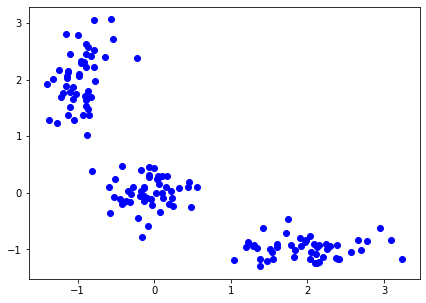

In [30]:
# генерация данных
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(7, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [35]:
# В scipy есть функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

# сгенерим три случайные центроиды 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    

    cent_history.append(centroids)

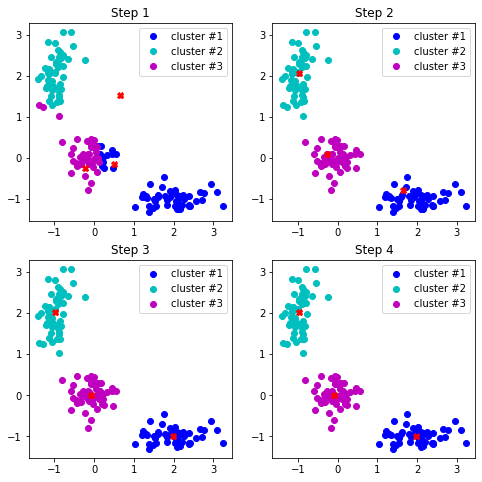

In [36]:
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

C:\Users\laptop\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


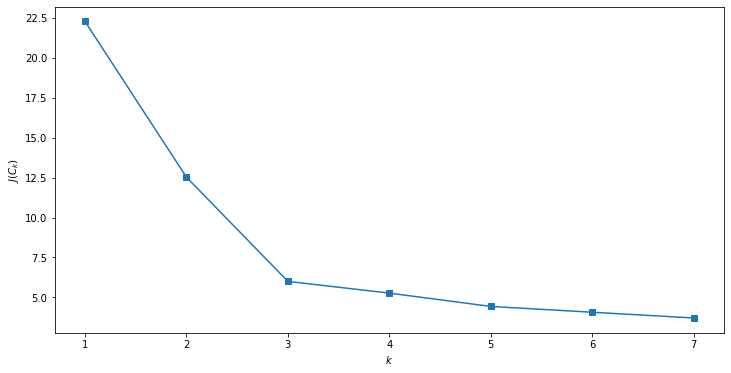

In [31]:
from sklearn.cluster import KMeans
 #Методом локтя определите оптимальное количество кластеров (наш график)
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [32]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(X)
kmeans.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [33]:
#Предсказываем единственный элемент

kmeans.predict([[0,0]])
# ответ array([0]) - точка попадает в нулевой кластер(рисунок выше)

array([0])

In [34]:
#Предсказываем единственный элемент

kmeans.predict([[2,-1]])
# ответ array([1]) - точка попадает в 1-й кластер(рисунок выше)

array([1])

## Иерархическая кластеризация

In [37]:
# генерация данных
X = np.zeros((15, 2))

np.random.seed(seed=42)
X[:5, 0] = np.random.normal(loc=0.0, scale=.3, size=5)
X[:5, 1] = np.random.normal(loc=0.0, scale=.3, size=5)

X[5:10, 0] = np.random.normal(loc=2.0, scale=.5, size=5)
X[5:10, 1] = np.random.normal(loc=-1.0, scale=.2, size=5)

X[10:15, 0] = np.random.normal(loc=-1.0, scale=.2, size=5)
X[10:15, 1] = np.random.normal(loc=2.0, scale=.5, size=5)


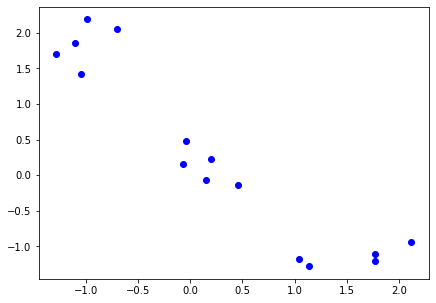

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

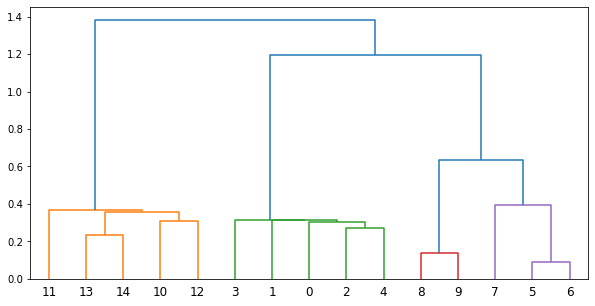

In [39]:
# Построение дерева иерархий
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

In [118]:
from sklearn.cluster import AgglomerativeClustering

In [119]:
agg = AgglomerativeClustering(n_clusters = 3)

In [202]:
#agg.fit_predict(X)

In [129]:
# Метрики
# from sklearn import metrics
# metrics.silhouette_score(X, agg.labels_)

# Снижение размерности

In [4]:
from sklearn import datasets


iris = datasets.load_iris()
X = iris.data
y = iris.target


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)
# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
#print('Accuracy: ',accuracy_score(y_test,preds))

In [8]:
# Понизим размерность с 4 до 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
#plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
#plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
#plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
#plt.legend(loc=0);

In [165]:
# Повторим классификацию деревом по построенному преобразованию данных
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
#print('Accuracy: ',accuracy_score(y_test,preds))

In [166]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

In [9]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [10]:
#plt.imshow(X[598].reshape((8,8)))

In [14]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

#plt.figure(figsize=(12,10))
#plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
#            edgecolor='none', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))
#plt.colorbar();



In [200]:
var = pca.explained_variance_ratio_
#var.sum()

In [13]:
# TSNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

#X_tsne = tsne.fit_transform(X)

#plt.figure(figsize=(12,10))
#plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
#            edgecolor='none', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))
#plt.colorbar();


In [187]:
#Как всегда возьмем дерево.
#и обучим на результате трансформации t-SNE
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [195]:
#print('Accuracy: ',accuracy_score(y_test,preds))

In [ ]:
# теперь посчитаем без tSNE но по 64 признакам

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [192]:
#print('Accuracy: ',accuracy_score(y_test,preds))